In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
train_set = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_set = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [5]:
model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
num_features = model.heads.head.in_features
model.heads.head = nn.Linear(num_features, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 197MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [11]:
epochs = 3
epoch_losses = []
batch_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", ncols=100)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_losses.append(loss.item())
        loop.set_postfix(loss=loss.item())
    epoch_losses.append(total_loss / len(train_loader))

# 1:26:35 on T4 GPU in Google Colab

Epoch 3/3: 100%|███████████████████████████████████| 1563/1563 [28:53<00:00,  1.11s/it, loss=0.0778]


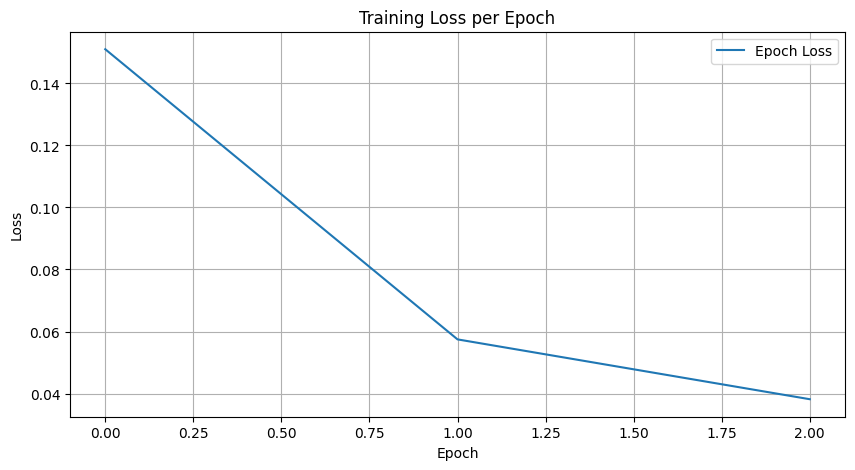

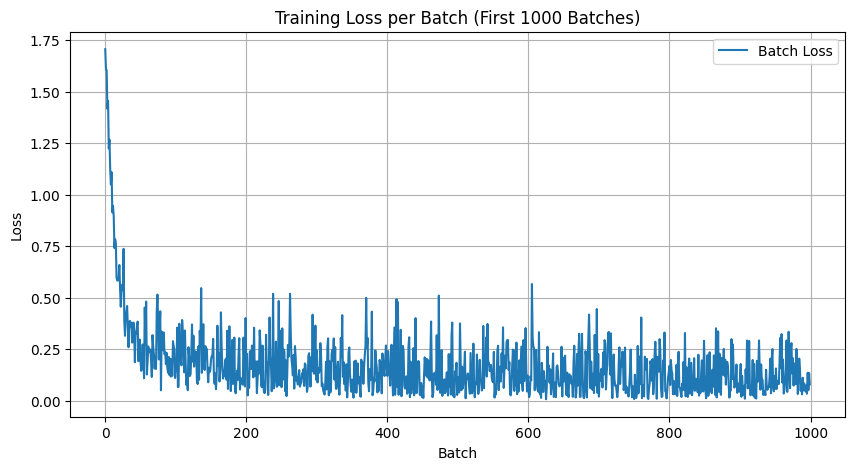

In [12]:
import matplotlib.pyplot as plt

# Plot epoch losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label="Epoch Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plot batch losses (first 1000 batches for clarity if there are too many)
plt.figure(figsize=(10, 5))
plt.plot(batch_losses[:1000], label="Batch Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per Batch (First 1000 Batches)")
plt.legend()
plt.grid(True)
plt.show()

# Training Loss per Epoch

Basically, your model is getting its act together fast — the loss drops hard from the first to second epoch, then keeps sliding down more slowly after that. That steep early drop means it learned the big, obvious patterns right away, and the smaller, gradual decreases after show it's still improving but at a chill, steady pace.

# Training Loss per Batch

This one's basically showing the messy, real-time vibes of training: the loss starts super high, crashes down fast in the first few batches, and then bounces around a lot while still trending downward overall. The wiggles are normal batch-to-batch noise, but the general slope says your model is consistently leveling up as it sees more data.

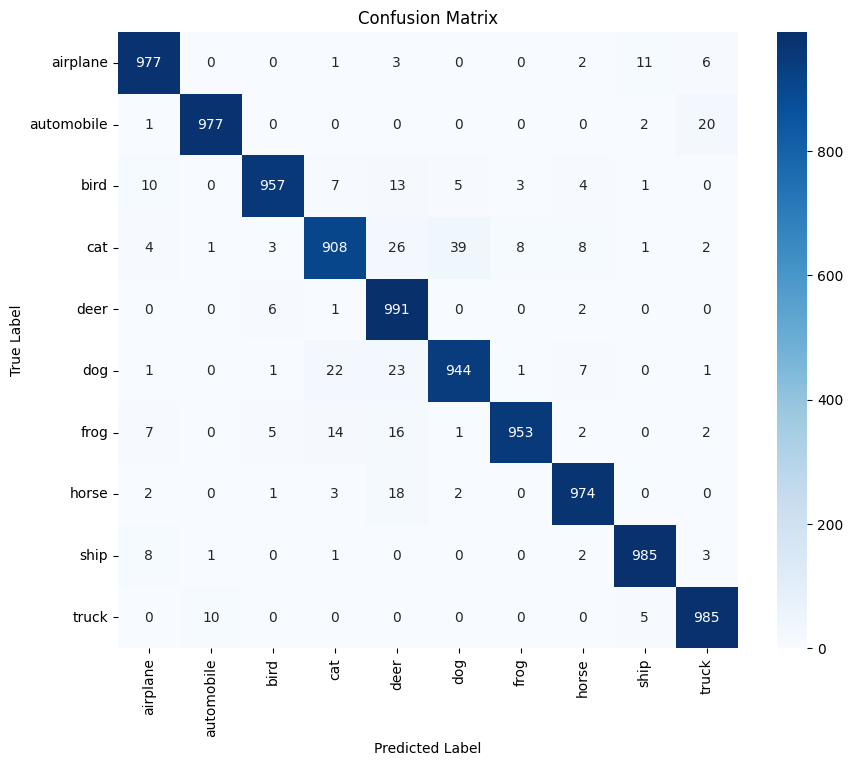

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Define class names for CIFAR-10
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

This confusion matrix shows that the model performs very well overall during evaluation, with high accuracy across most classes (diagonal values ranging from 908-991 indicate correct predictions). However, there are some notable confusion patterns: cats are frequently misclassified as deer (26) and dogs (39), while dogs show confusion with cats (22) and deer (23). The frog class also shows some misclassification into cat (14) and deer (16). The airplane, automobile, ship, and truck classes demonstrate near-perfect classification with minimal confusion, suggesting the model has learned these categories very distinctly, while animals with similar features show more inter-class confusion.

Test Accuracy: 0.9651


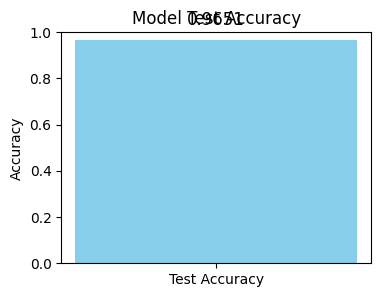

In [15]:
import matplotlib.pyplot as plt

model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc = correct / total
print(f"Test Accuracy: {acc:.4f}")

# Plotting the test accuracy
plt.figure(figsize=(4, 3))
plt.bar(["Test Accuracy"], [acc], color="skyblue")
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.ylabel("Accuracy")
plt.title("Model Test Accuracy")
plt.text(0, acc + 0.05, f"{acc:.4f}", ha="center", va="bottom", fontsize=12)
plt.show()

Your model achieved a test accuracy of **0.9651**, which is excellent. The bar chart visually represents this high accuracy. This indicates that your model is performing very well on unseen data.

In [16]:
Path("models").mkdir(exist_ok=True, parents=True)
torch.save(model.state_dict(), "models/vit_cifar10.pth")
print("Model saved to models/vit_cifar10.pth")

Model saved to models/vit_cifar10.pth
